# AI Lab Run
V1: New dataset, old model.   
A3: untrain model.   
A5: this time we change the traning target to predicting the phoneme of each frame (which we can grab from the matched phone guide). From this we again check the several matters concerned and evaluate how well it can be guided to learned the phonemes. 

A6: This time we use CTC as prediction loss. 

In [60]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchaudio.models.decoder import ctc_decoder

In [2]:
from model_model import PhonePredCTCNet as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDatasetPhoneseq as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
# from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 256

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.7

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [39]:
ts = str(get_timestamp())
# ts = "0204220436"
stop_epoch = "149"
train_name = "A_03"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))

train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

A_03-0204220436


In [6]:
READ = False
# READ = True

In [7]:
DATAREAD = False

In [8]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "train-phoneseq.gt"))
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "valid-phoneseq.gt"))

use_proportion = 0.3

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [9]:
train_num, valid_num, len(train_loader), len(valid_loader)

(231830, 31142, 906, 122)

In [10]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens, yy_pad, y_lens = sample_data
print(xx_pad.shape)

torch.Size([256, 62, 64])


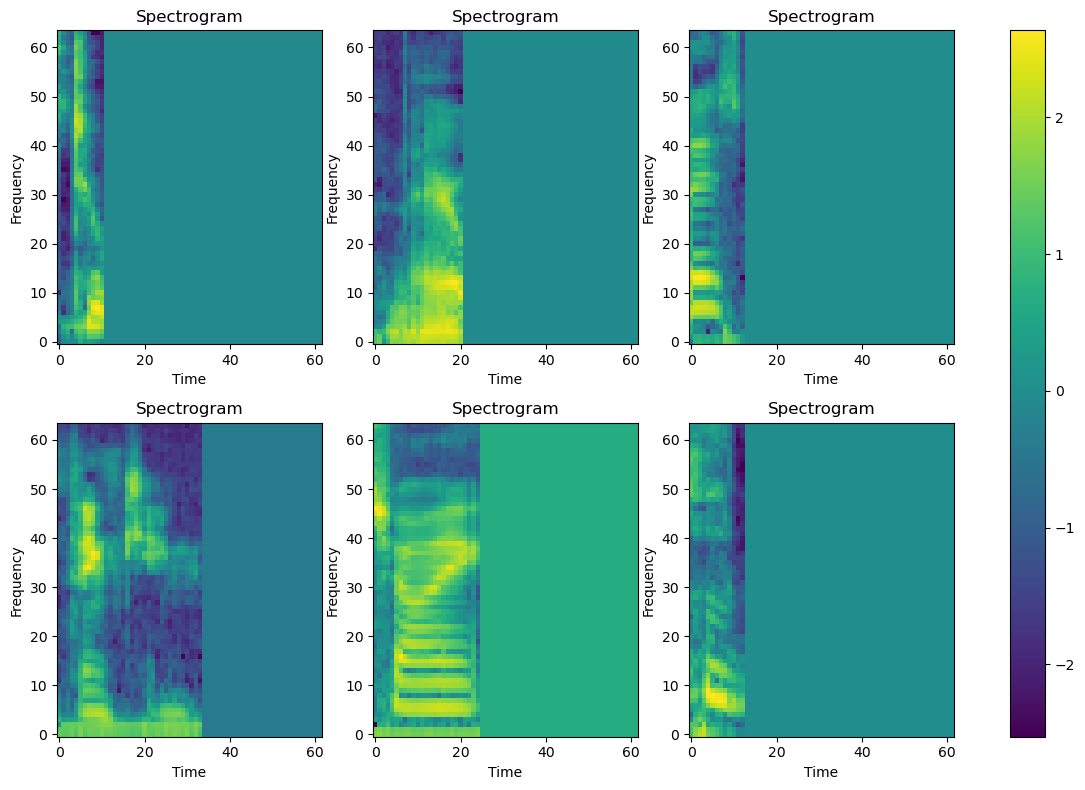

In [11]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Prepare model

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_loss = nn.CTCLoss(blank=mymap.encode("BLANK"))
# model_loss = MaskedFlatLoss(recon_loss)

model = TheLearner(enc_size_list=ENC_SIZE_LIST, out_dim=mymap.token_num(), num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [41]:
# # initialize model weights
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.orthogonal_(m.weight)
#         m.bias.data.fill_(0.01)
#     if isinstance(m, nn.LSTM): 
#         for name, p in m.named_parameters():
#             if "weight" in name: 
#                 nn.init.orthogonal_(p)
#             elif "bias" in name: 
#                 nn.init.constant_(p, 0)

# model.apply(init_weights)

In [42]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [43]:
params

7920

### Load model if READ

In [44]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [52]:
EPOCHS = 30
BASE = 30

In [53]:
def count_correct(pred, truth, mask): 
    # Because we have padding, so we need masking. 
    total = torch.sum(mask) # this excludes non-masked
    correct = torch.sum((pred == truth) * mask)
    return correct.item(), total.item()

In [54]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_total = 0
        train_correct = 0
        for idx, (x, x_lens, y, y_lens) in enumerate(train_loader):
            # y_lens should be the same as x_lens
            optimizer.zero_grad()
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)
            y = y.long()

            x_hat = model(x, x_lens, x_mask)
            # print(x_hat, y, x_mask.shape)
            # Here x_hat: (B, L, C); we change to (L, B, C)
            x_hat = x_hat.permute(1, 0, 2)

            # loss = model_loss.get_loss(x_hat, y, x_mask)
            loss = model_loss(x_hat, y, x_lens, y_lens)

            train_loss += loss.item()

            loss.backward()
            
            # # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # # 这个函数计算的是全局梯度范数
            # # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # # parameters: an iterable of Variables that will have gradients normalized
            # # max_norm: max norm of the gradients(阈值设定)
            # # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            # pred = model.predict_on_output(x_hat)
            # this_correct, this_total = count_correct(pred, y, x_mask)
            # train_total += this_total
            # train_correct += this_correct

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        # train_accs.append(train_correct / train_total)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_total = 0
        valid_correct = 0
        for idx, (x, x_lens, y, y_lens) in enumerate(valid_loader):
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)
            y = y.long()

            x_hat = model(x, x_lens, x_mask)

            x_hat = x_hat.permute(1, 0, 2)

            # loss = model_loss.get_loss(x_hat, y, x_mask)
            loss = model_loss(x_hat, y, x_lens, y_lens)

            valid_loss += loss.item()

            # pred = model.predict_on_output(x_hat)
            # this_correct, this_total = count_correct(pred, y, x_mask)
            # valid_total += this_total
            # valid_correct += this_correct

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        # valid_accs.append(valid_correct / valid_total)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [55]:
if __name__ == "__main__": 
    train()

Epoch 30
Training loss  2.600 in Step 0
Training loss  2.627 in Step 100
Training loss  2.558 in Step 200
Training loss  2.558 in Step 300
Training loss  2.648 in Step 400
Training loss  2.669 in Step 500
Training loss  2.599 in Step 600
Training loss  2.598 in Step 700
Training loss  2.637 in Step 800
Training loss  2.631 in Step 900
※※※Training loss  2.614※※※
Valid loss  2.611 in Step 0
Valid loss  2.638 in Step 50
Valid loss  2.688 in Step 100
※※※Valid loss  2.640※※※
Epoch 31
Training loss  2.698 in Step 0
Training loss  2.569 in Step 100
Training loss  2.601 in Step 200
Training loss  2.587 in Step 300
Training loss  2.472 in Step 400
Training loss  2.591 in Step 500
Training loss  2.588 in Step 600
Training loss  2.580 in Step 700
Training loss  2.638 in Step 800
Training loss  2.618 in Step 900
※※※Training loss  2.609※※※
Valid loss  2.609 in Step 0
Valid loss  2.630 in Step 50
Valid loss  2.696 in Step 100
※※※Valid loss  2.638※※※
Epoch 32
Training loss  2.720 in Step 0
Training l

In [56]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

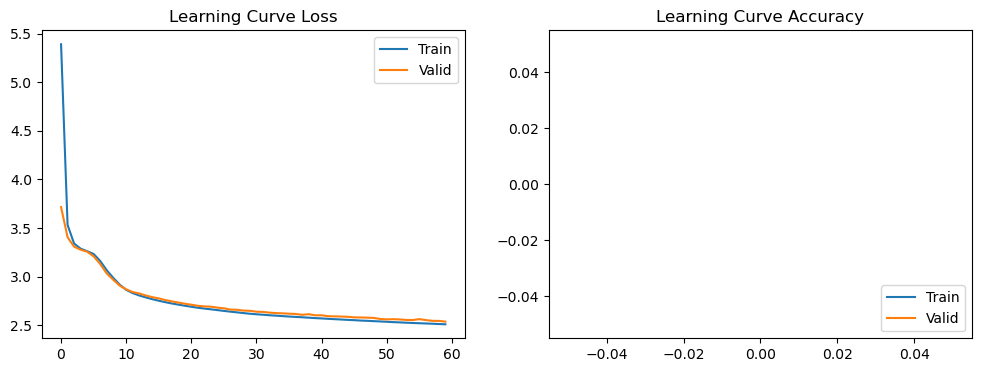

In [57]:
start, end = 0, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot Loss on the left subplot
ax1.plot(train_losses.get()[start:end], label='Train')
ax1.plot(valid_losses.get()[start:end], label='Valid')
ax1.set_title("Learning Curve Loss")
ax1.legend(loc="upper right")

# Plot Accuracy on the right subplot
ax2.plot(train_accs.get()[start:end], label='Train')
ax2.plot(valid_accs.get()[start:end], label='Valid')
ax2.set_title('Learning Curve Accuracy')
ax2.legend(loc="lower right")

## Testing

In [58]:
test_ds = ThisDataset(rec_dir, 
                       test_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "test-phoneseq.gt"))

use_test_ds = test_ds

# use_proportion = 0.3

# if READ or DATAREAD: 
#     train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
#     valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

#     use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
#     use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
# else: 
#     # train data
#     use_len = int(use_proportion * len(train_ds))
#     remain_len = len(train_ds) - use_len
#     use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

#     # valid data
#     use_len = int(use_proportion * len(valid_ds))
#     remain_len = len(valid_ds) - use_len
#     use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

#     # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
#     # the saved train and valid separations will reflect this
#     DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
#     DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
test_num = len(test_loader.dataset)

In [64]:
model.eval()
test_loss = 0.
test_num = len(test_loader)
preds = []
for idx, (x, x_lens, y, y_lens) in enumerate(test_loader):
    x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
    
    x = x.to(device)
    y = y.to(device)
    y = y.long()

    x_hat = model(x, x_lens, x_mask)

    pred_x = model.predict_on_output(x_hat)
    # preds.append(pred_x.cpu().apply_(mymap.decode))

    x_hat = x_hat.permute(1, 0, 2)

    # loss = model_loss.get_loss(x_hat, y, x_mask)
    loss = model_loss(x_hat, y, x_lens, y_lens)

    test_loss += loss.item()

    # pred = model.predict_on_output(x_hat)
    # this_correct, this_total = count_correct(pred, y, x_mask)
    # valid_total += this_total
    # valid_correct += this_correct

/home/franklhtan/Projects/wavln/script/model_dataset.py:231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ground_truth = self.ground_truth_set[idx]
/home/franklhtan/Projects/wavln/script/model_dataset.py:231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ground_truth = self.ground_truth_set[idx]
/home/franklhtan/Projects/wavln/script/model_dataset.py:231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ground_truth = self.ground_trut

tensor([[16,  0,  0,  ..., 31, 31, 31],
        [10,  0,  0,  ..., 31, 31, 31],
        [10,  0,  0,  ..., 31, 31, 31],
        ...,
        [ 3,  0,  0,  ..., 31, 31, 31],
        [ 3,  0,  0,  ..., 31, 31, 31],
        [36,  0,  0,  ..., 31, 31, 31]], device='cuda:0')


Exception: 

In [61]:
# ctc_decoder(
#     lexicon=None, 
#     tokens=mylist, 
#     blank_token="BLANK"
# )

ValueError: Unknown entry in dictionary: '|'

## Conclusion
This model should converge to loss around 0.49x. 